In [8]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import pandas as pd

# Federal Reserve dataset: https://www.kaggle.com/federalreserve/interest-rates
reserve = pd.read_csv(
    "/content/drive/MyDrive/kaggle/Time_Series/dataset/reserve.csv",
    parse_dates={'Date': ['Year', 'Month', 'Day']},
    index_col='Date',
)

y = reserve.loc[:, 'Unemployment Rate'].dropna().to_period('M')
df = pd.DataFrame({
    'y': y,
    'y_lag_1': y.shift(1),
    'y_lag_2': y.shift(2),    
})

df.head()

,y,y_lag_1,y_lag_2
Date,,,
1954-07,5.8,NaN,NaN
1954-08,6.0,5.8,NaN
1954-09,6.1,6.0,5.8
1954-10,5.7,6.1,6.0
1954-11,5.3,5.7,6.1


In [10]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.signal import periodogram
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_pacf

simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlesize=16, titlepad=10)
plot_params = dict(color="0.75", style=".-", markeredgecolor="0.25", markerfacecolor="0.25")
%config InlineBackend.figure_format = 'retina'

def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(alpha=0.75, s=3)
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_, y=y_, scatter_kws=scatter_kws, line_kws=line_kws, lowess=True, ax=ax, **kwargs)
    at = AnchoredText(f"{corr:.2f}", prop=dict(size="large"), frameon=True, loc="upper left")
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax

def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig


data_dir = Path("/content/drive/MyDrive/kaggle/Time_Series/dataset")
flu_trends = pd.read_csv(data_dir / "flu-trends.csv")
flu_trends.set_index(pd.PeriodIndex(flu_trends.Week, freq="W"), inplace=True)
flu_trends.drop("Week", axis=1, inplace=True)

In [11]:
flu_trends.head()

,AInfluenza,AcuteBronchitis,BodyTemperature,BraunThermoscan,BreakAFever,Bronchitis,ChestCold,ColdAndFlu,ColdOrFlu,ColdVersusFlu,...,TreatingTheFlu,TreatmentForFlu,TreatmentForTheFlu,Tussin,Tussionex,TypeAInfluenza,UpperRespiratory,WalkingPneumonia,WhatToDoIfYouHaveTheFlu,FluVisits
Week,,,,,,,,,,,,,,,,,,,,,
2009-06-29/2009-07-05,36,20,43,27,11,22,16,7,3,8,...,16,6,13,25,34,30,25,24,15,180
2009-07-06/2009-07-12,25,19,40,31,10,21,11,6,8,8,...,16,7,8,27,32,27,28,29,9,115
2009-07-13/2009-07-19,24,30,45,20,12,20,20,6,6,8,...,16,6,9,24,28,25,25,25,9,132
2009-07-20/2009-07-26,23,19,40,15,10,19,12,7,10,15,...,8,5,12,21,26,26,29,24,13,109
2009-07-27/2009-08-02,27,21,44,20,11,19,17,8,10,15,...,8,8,12,33,29,21,27,30,9,120


In [12]:
flu_trends.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 366 entries, 2009-06-29/2009-07-05 to 2016-06-27/2016-07-03
Freq: W-SUN
Columns: 130 entries, AInfluenza to FluVisits
dtypes: int64(130)
memory usage: 374.6 KB


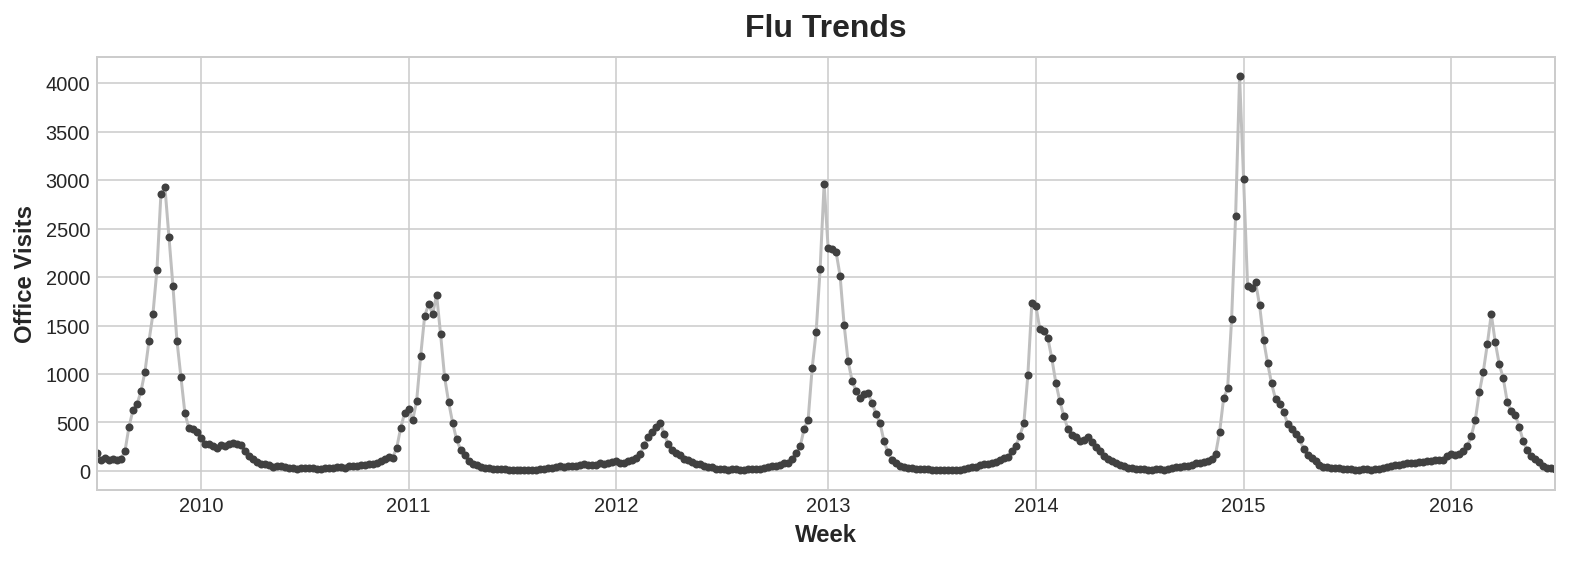

In [13]:
ax = flu_trends.FluVisits.plot(title='Flu Trends', **plot_params)
_ = ax.set(ylabel="Office Visits")

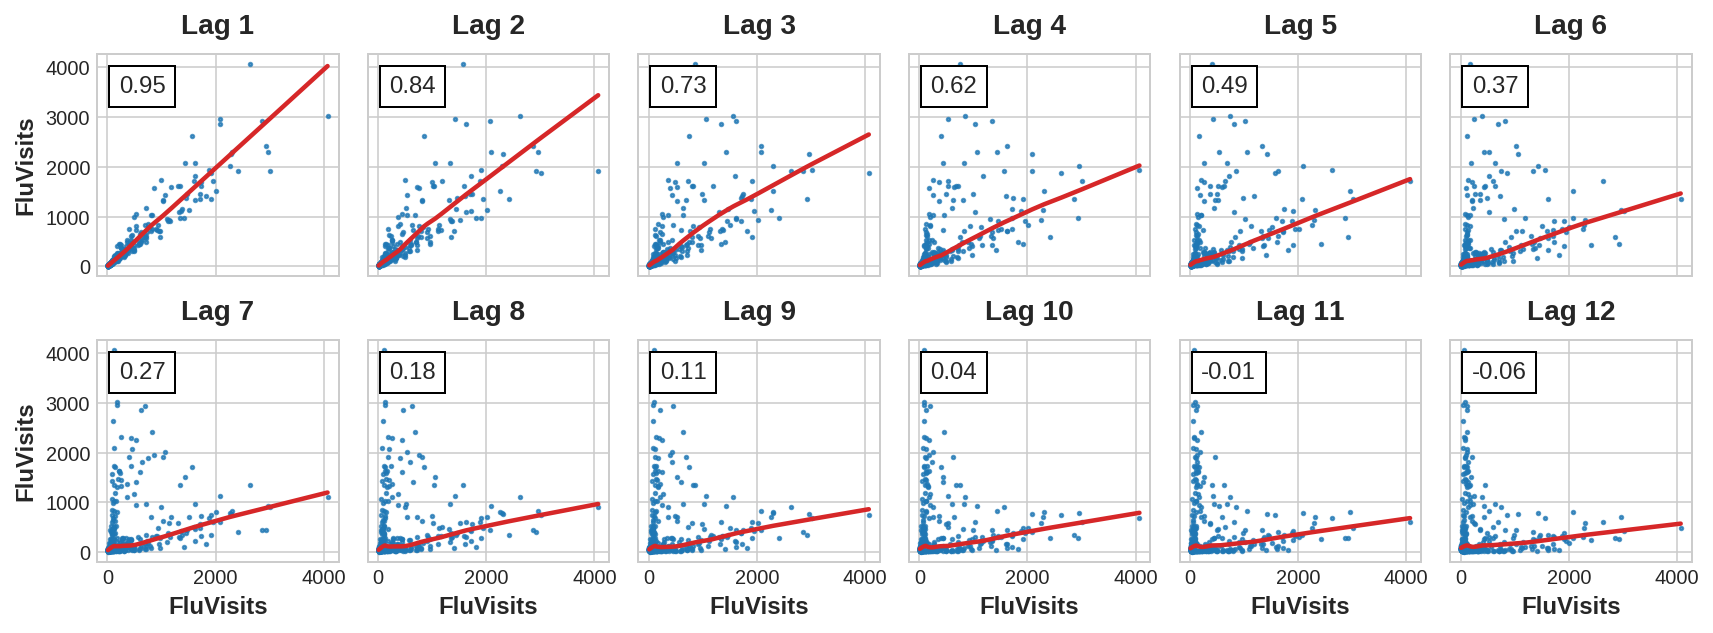

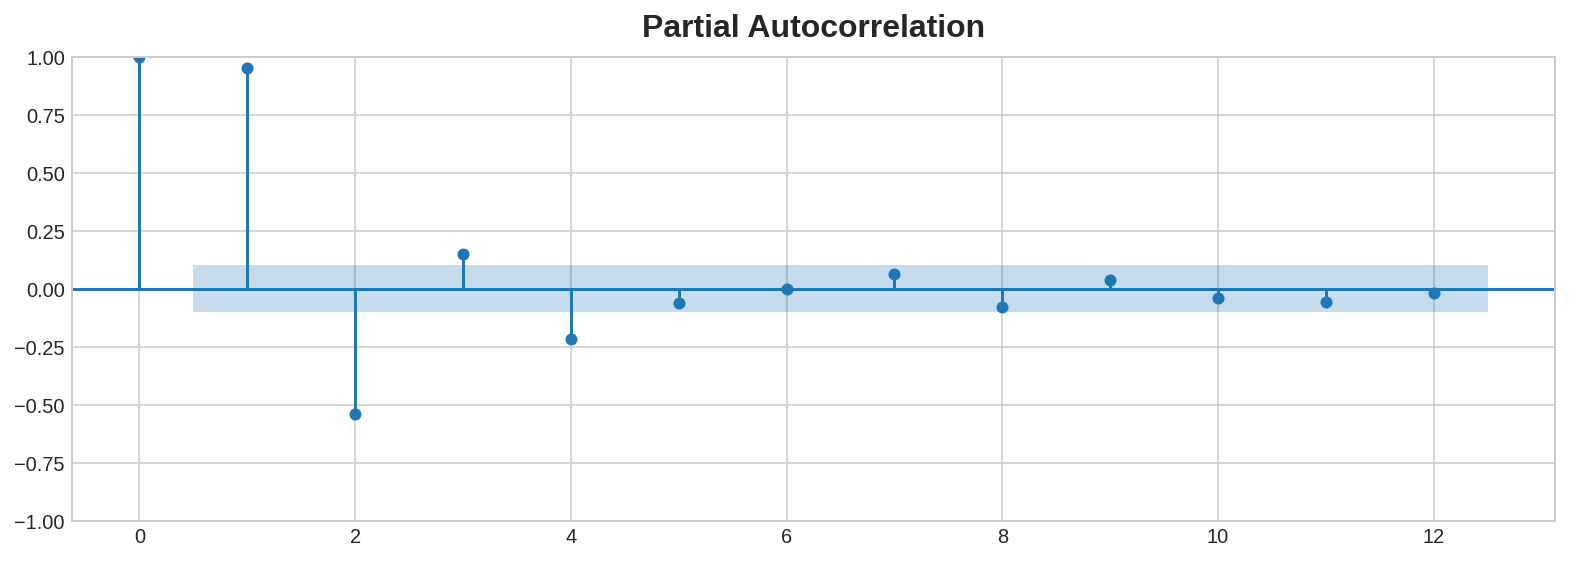

In [14]:
_ = plot_lags(flu_trends.FluVisits, lags=12, nrows=2)
_ = plot_pacf(flu_trends.FluVisits, lags=12)

In [15]:
def make_lags(ts, lags):
    return pd.concat(
        {f'y_lag_{i}': ts.shift(i) for i in range(1, lags + 1)}, axis=1)

X = make_lags(flu_trends.FluVisits, lags=4)
X = X.fillna(0.0)

In [19]:
X.head()

,y_lag_1,y_lag_2,y_lag_3,y_lag_4
Week,,,,
2009-06-29/2009-07-05,0.0,0.0,0.0,0.0
2009-07-06/2009-07-12,180.0,0.0,0.0,0.0
2009-07-13/2009-07-19,115.0,180.0,0.0,0.0
2009-07-20/2009-07-26,132.0,115.0,180.0,0.0
2009-07-27/2009-08-02,109.0,132.0,115.0,180.0


In [16]:
# Create target series and data splits
y = flu_trends.FluVisits.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=60, shuffle=False)

# Fit and predict
model = LinearRegression()  # `fit_intercept=True` since we didn't use DeterministicProcess
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

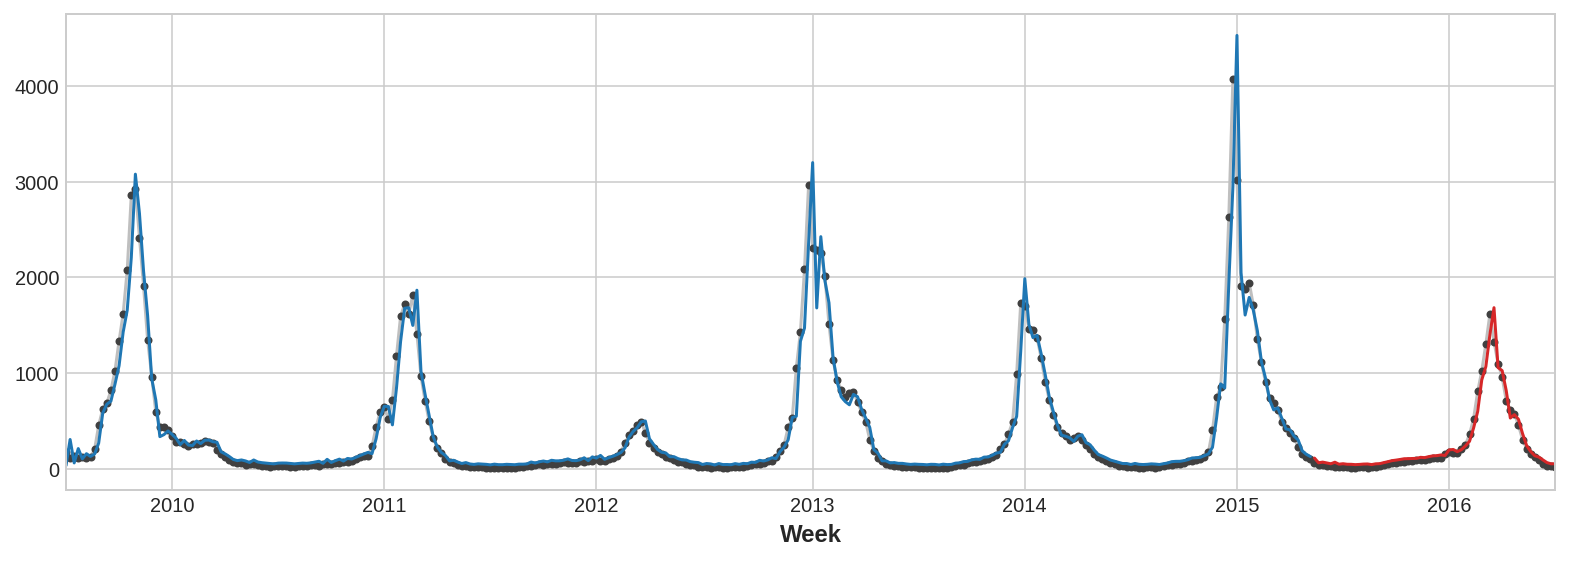

In [17]:
ax = y_train.plot(**plot_params)
ax = y_test.plot(**plot_params)
ax = y_pred.plot(ax=ax)
_ = y_fore.plot(ax=ax, color='C3')

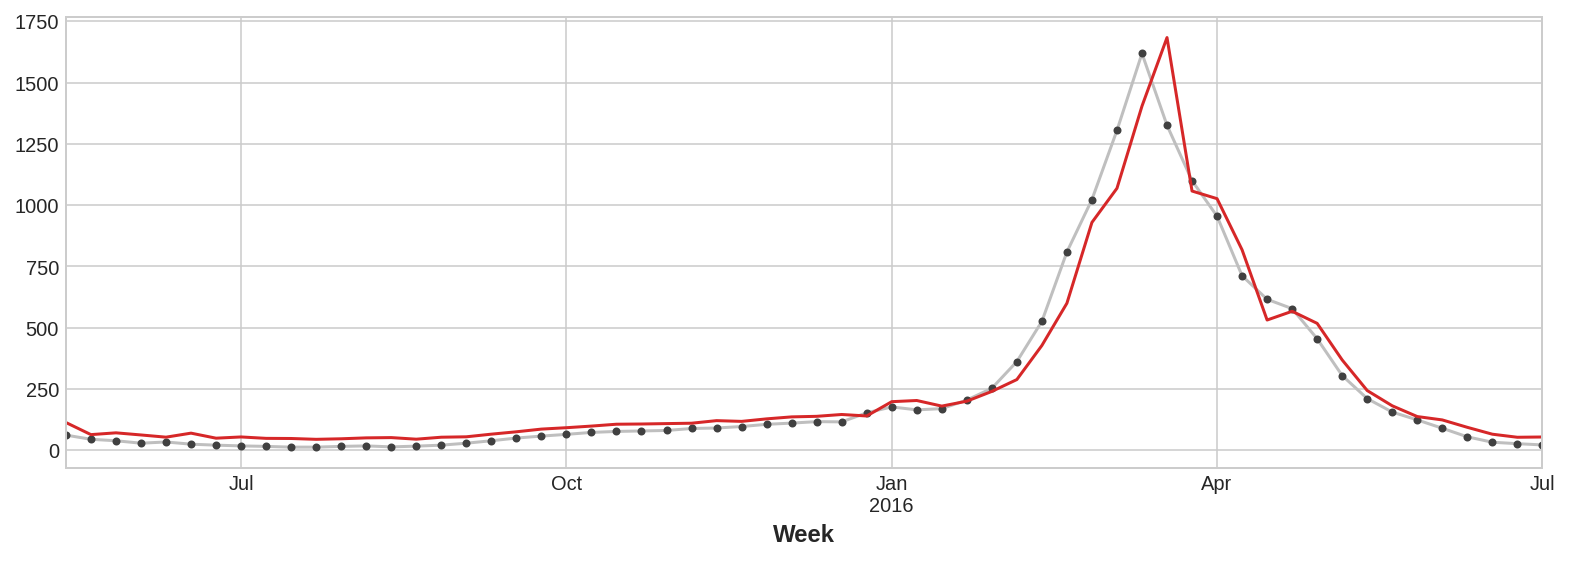

In [18]:
ax = y_test.plot(**plot_params)
_ = y_fore.plot(ax=ax, color='C3')

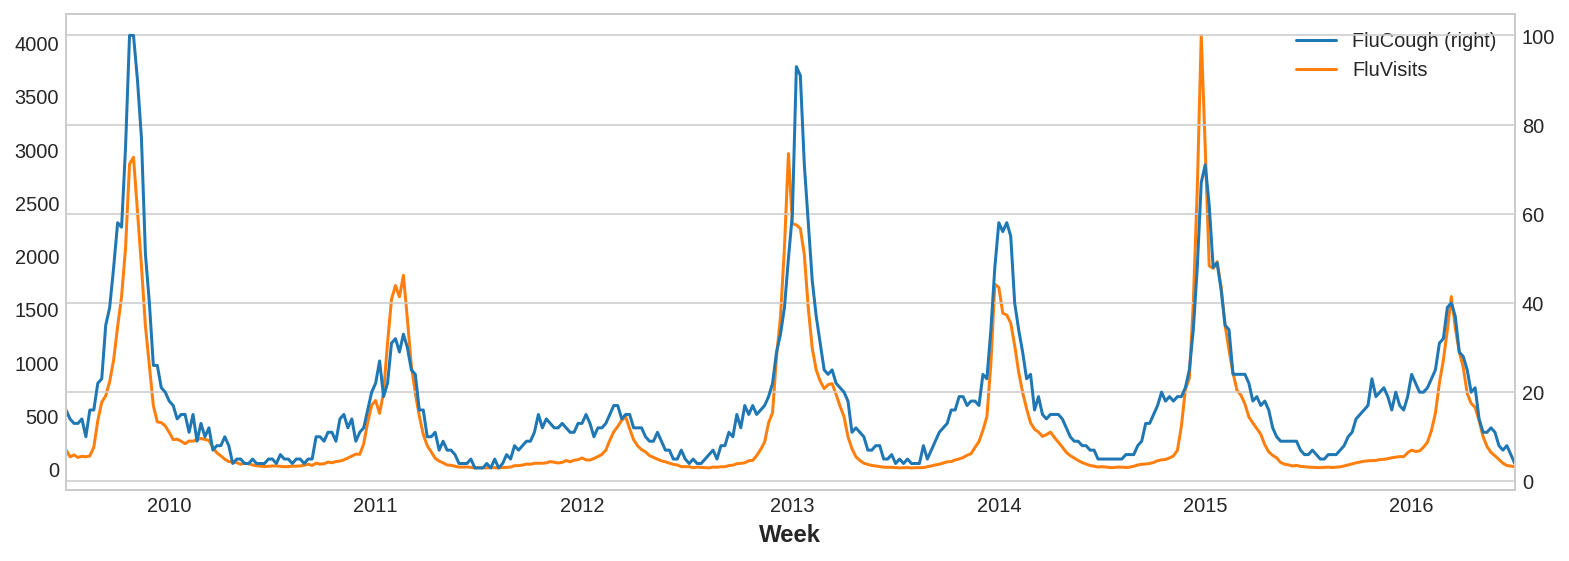

In [20]:
ax = flu_trends.plot(
    y=["FluCough", "FluVisits"],
    secondary_y="FluCough",
)

In [21]:
search_terms = ["FluContagious", "FluCough", "FluFever", "InfluenzaA", "TreatFlu", "IHaveTheFlu", "OverTheCounterFlu", "HowLongFlu"]

# Create three lags for each search term
X0 = make_lags(flu_trends[search_terms], lags=3)

# Create four lags for the target, as before
X1 = make_lags(flu_trends['FluVisits'], lags=4)

# Combine to create the training data
X = pd.concat([X0, X1], axis=1).fillna(0.0)

In [22]:
X.head()

,"(y_lag_1, FluContagious)","(y_lag_1, FluCough)","(y_lag_1, FluFever)","(y_lag_1, InfluenzaA)","(y_lag_1, TreatFlu)","(y_lag_1, IHaveTheFlu)","(y_lag_1, OverTheCounterFlu)","(y_lag_1, HowLongFlu)","(y_lag_2, FluContagious)","(y_lag_2, FluCough)",...,"(y_lag_3, FluFever)","(y_lag_3, InfluenzaA)","(y_lag_3, TreatFlu)","(y_lag_3, IHaveTheFlu)","(y_lag_3, OverTheCounterFlu)","(y_lag_3, HowLongFlu)",y_lag_1,y_lag_2,y_lag_3,y_lag_4
Week,,,,,,,,,,,,,,,,,,,,,
2009-06-29/2009-07-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009-07-06/2009-07-12,5.0,16.0,15.0,36.0,6.0,5.0,11.0,6.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,180.0,0.0,0.0,0.0
2009-07-13/2009-07-19,6.0,14.0,15.0,25.0,12.0,7.0,7.0,7.0,5.0,16.0,...,0.0,0.0,0.0,0.0,0.0,0.0,115.0,180.0,0.0,0.0
2009-07-20/2009-07-26,6.0,13.0,13.0,24.0,8.0,8.0,7.0,7.0,6.0,14.0,...,15.0,36.0,6.0,5.0,11.0,6.0,132.0,115.0,180.0,0.0
2009-07-27/2009-08-02,5.0,13.0,12.0,23.0,5.0,4.0,6.0,6.0,6.0,13.0,...,15.0,25.0,12.0,7.0,7.0,7.0,109.0,132.0,115.0,180.0


In [25]:
def convert_column_name(col):
  return "_".join(col)

X.columns = X.columns.map(convert_column_name)

In [26]:
X.head()

,y_lag_1_FluContagious,y_lag_1_FluCough,y_lag_1_FluFever,y_lag_1_InfluenzaA,y_lag_1_TreatFlu,y_lag_1_IHaveTheFlu,y_lag_1_OverTheCounterFlu,y_lag_1_HowLongFlu,y_lag_2_FluContagious,y_lag_2_FluCough,...,y_lag_3_FluFever,y_lag_3_InfluenzaA,y_lag_3_TreatFlu,y_lag_3_IHaveTheFlu,y_lag_3_OverTheCounterFlu,y_lag_3_HowLongFlu,y___l_a_g___1,y___l_a_g___2,y___l_a_g___3,y___l_a_g___4
Week,,,,,,,,,,,,,,,,,,,,,
2009-06-29/2009-07-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009-07-06/2009-07-12,5.0,16.0,15.0,36.0,6.0,5.0,11.0,6.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,180.0,0.0,0.0,0.0
2009-07-13/2009-07-19,6.0,14.0,15.0,25.0,12.0,7.0,7.0,7.0,5.0,16.0,...,0.0,0.0,0.0,0.0,0.0,0.0,115.0,180.0,0.0,0.0
2009-07-20/2009-07-26,6.0,13.0,13.0,24.0,8.0,8.0,7.0,7.0,6.0,14.0,...,15.0,36.0,6.0,5.0,11.0,6.0,132.0,115.0,180.0,0.0
2009-07-27/2009-08-02,5.0,13.0,12.0,23.0,5.0,4.0,6.0,6.0,6.0,13.0,...,15.0,25.0,12.0,7.0,7.0,7.0,109.0,132.0,115.0,180.0


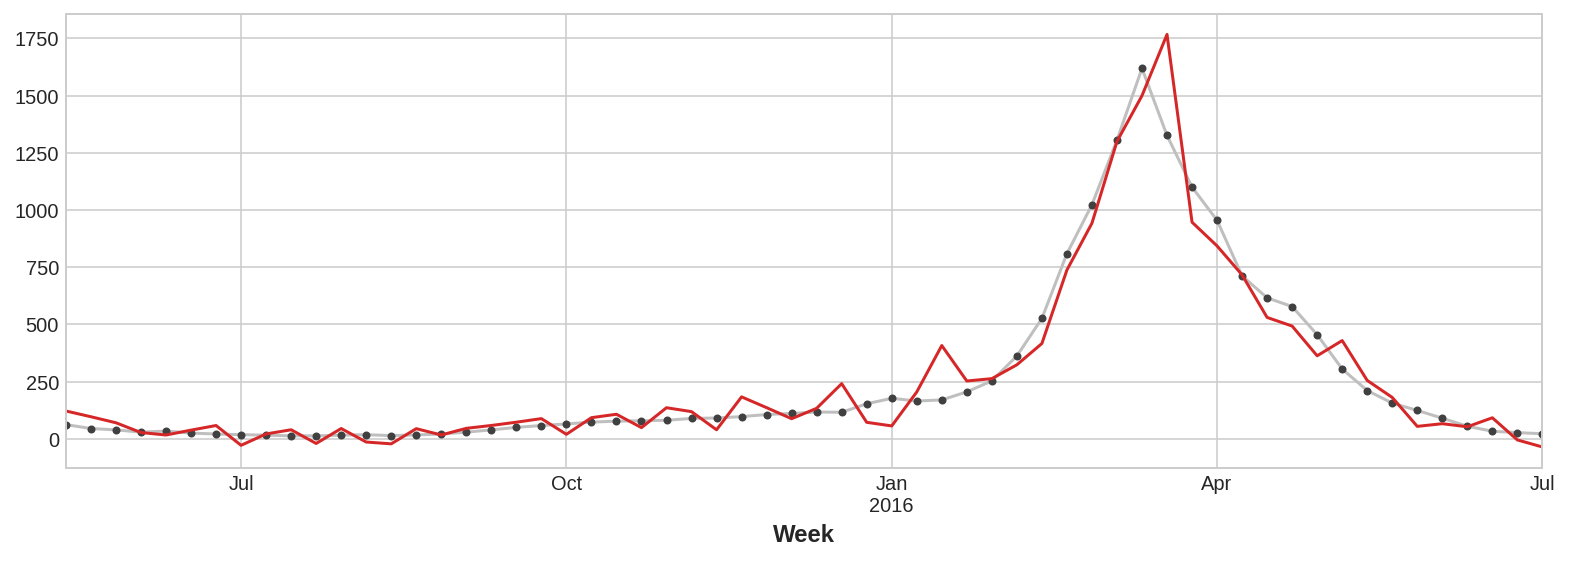

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=60, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

ax = y_test.plot(**plot_params)
_ = y_fore.plot(ax=ax, color='C3')